In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import model
import options
import assetmodel

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [5]:
TRAINING_DATE_START = pd.to_datetime('2017-03-27')
TRAINING_DATE_END = pd.to_datetime('2018-03-27')

TEST_DATE_START = pd.to_datetime('2018-03-28')
TEST_DATE_END = pd.to_datetime('2018-12-27')

TRADING_DAYS_TILL_EXPIRY = int(0.75*250)

RISK_FREE_R = 0.03
WIG_20 = np.array(["ACP","CDR","JSW","LTS","PEO","PKN","SPL","ALE","CPS","KGH","MRC","PGE","PKO","TPE","CCC","DNP","LPP","OPL","PGN","PZU"])

In [6]:
def ReadAndPreprocess(url, ticker):
    data = pd.read_csv(url)
    data['Data'] = pd.to_datetime(data['Data'])
    data['Zwroty_dzienne'] = data['Zamkniecie'].pct_change()
    # log (S_{t+1} / S_t)
    data['Log_ratio'] = np.log(data['Zamkniecie']/ data['Zamkniecie'].shift(1))
    data['Company'] = ticker
    return data
  

def ReadWig20DailyPrices(url_prefix = 'https://raw.githubusercontent.com/wfica/stochastic-fin-maths/main/notowania_wig_20/',):
    df = pd.DataFrame()
    for company in WIG_20:
        url = url_prefix + company[:3].lower() + '_d.csv'
        data = ReadAndPreprocess(url, company)
        df = df.append(data, ignore_index=True)
    data = ReadAndPreprocess(url_prefix +'wig20_d.csv', 'W20')
    df = df.append(data, ignore_index=True)
    return df


wig_20_all = ReadWig20DailyPrices()

In [7]:
wigTraining = wig_20_all.loc[(wig_20_all['Data'] >= TRAINING_DATE_START) & (wig_20_all['Data'] < TRAINING_DATE_END) & (wig_20_all['Company'] == 'W20')]['Zamkniecie'].to_numpy()
kghmTraining = wig_20_all.loc[(wig_20_all['Data'] >= TRAINING_DATE_START) & (wig_20_all['Data'] < TRAINING_DATE_END) & (wig_20_all['Company'] == 'KGH')]['Zamkniecie'].to_numpy()

wigTest = wig_20_all.loc[(wig_20_all['Data'] >= TEST_DATE_START) & (wig_20_all['Data'] < TEST_DATE_END) & (wig_20_all['Company'] == 'W20')]['Zamkniecie'].to_numpy()
kghmTest = wig_20_all.loc[(wig_20_all['Data'] >= TEST_DATE_START) & (wig_20_all['Data'] < TEST_DATE_END) & (wig_20_all['Company'] == 'KGH')]['Zamkniecie'].to_numpy()



In [8]:
modelPrices = {"W20": wigTraining, "KGH": kghmTraining}

In [9]:
pricing = model.Model(modelPrices, RISK_FREE_R)

In [10]:
trajectories, rd = pricing.MonteCarloRealRN(TRADING_DAYS_TILL_EXPIRY)

In [11]:
wigAOption = options.CallOption(wigTraining, 0.03, 2200, TRADING_DAYS_TILL_EXPIRY)
wigAOption.update(2203.7, TRADING_DAYS_TILL_EXPIRY)
print("Black scholes price:", wigAOption.value())

Black scholes price: 142.44418340470747


<Figure size 1440x720 with 0 Axes>

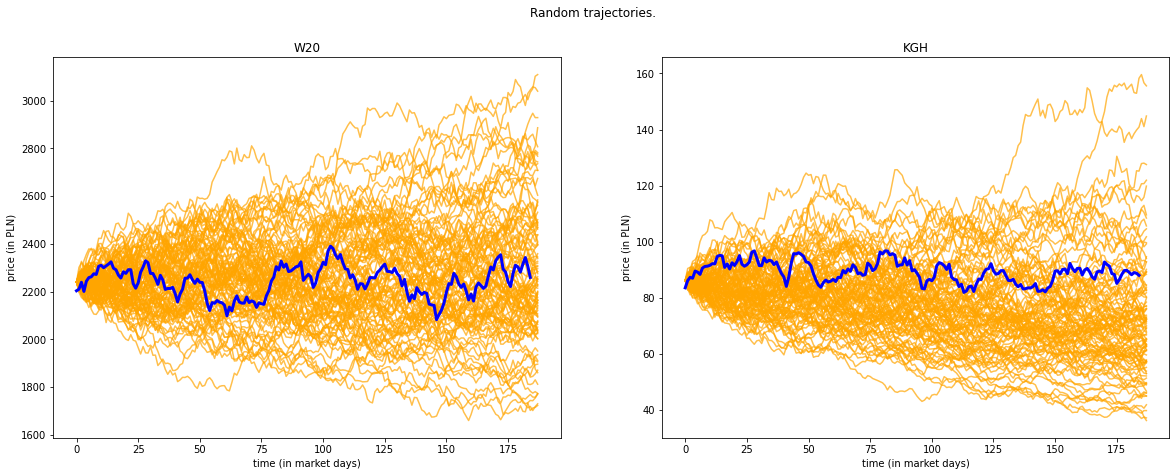

In [12]:
figure(figsize=(20, 10))
fig, axs = plt.subplots( 1,len(pricing.assets), figsize=(20, 7) )
fig.suptitle('Random trajectories.')
for ax in axs.flat:
    ax.set(xlabel='time (in market days)', ylabel='price (in PLN)')

s = 0
for _ in range(100):
    trajectories, rd = pricing.MonteCarloRealRN(TRADING_DAYS_TILL_EXPIRY)
    s += wigAOption.payoff(trajectories[:,0])*rd/np.exp(0.03)
    for i in range(len(pricing.assets)):
        axs[i].plot(trajectories[:,i], c='orange', alpha=0.7)

for i, asset in enumerate(pricing.assets):
    axs[i].set_title(asset.name) 
    if asset.name == 'W20':
        axs[i].plot(wigTest,c='blue', linewidth=3.0)
    elif asset.name == 'KGH':
        axs[i].plot(kghmTest,c='blue', linewidth=3.0)

In [13]:
pricing.assets[0].name

'W20'

In [14]:
s / 100.

151.58751259983663

In [15]:
values = pricing.PriceOption(wigAOption, base_asset_idx=pricing.getAssetIdx('W20'))
value

150.6247874817708

In [18]:
values= [pricing.PriceOption(wigAOption, base_asset_idx=pricing.getAssetIdx('W20')) for i in range(50)]
values

[170.31395755491928,
 152.73578075481694,
 178.9811330229004,
 136.44737572753692,
 193.6208349583119,
 172.16323846744672,
 175.44268815519683,
 180.42102409698865,
 140.426181895414,
 163.03761572416934,
 176.80004795035046,
 153.39444706565553,
 206.18091063498693,
 148.33332981937187,
 166.72522490107565,
 156.01810258981342,
 185.92317954539817,
 130.9790602020542,
 183.86558687354716,
 158.79148000723018,
 156.84008529380677,
 146.83477554421813,
 193.6416045548423,
 143.0644329177802,
 165.08901758483933,
 163.46713597310824,
 175.91082571424445,
 170.3637783391153,
 209.14858506973778,
 179.4651842979598,
 158.05315247097695,
 190.93121370814734,
 124.54050038022405,
 182.9648868812983,
 150.3039506009692,
 155.7186725104451,
 156.26079877044253,
 195.01779097206895,
 184.2837555029797,
 163.3453850636603,
 126.01657749012064,
 185.63696095501538,
 180.88136238063464,
 188.25898065457855,
 148.10287620409173,
 136.43508302377697,
 140.88777625324235,
 211.59337440232403,
 189.2

(array([3., 4., 5., 8., 6., 5., 8., 7., 1., 3.]),
 array([124.54050038, 133.24578778, 141.95107518, 150.65636259,
        159.36164999, 168.06693739, 176.77222479, 185.4775122 ,
        194.1827996 , 202.888087  , 211.5933744 ]),
 <BarContainer object of 10 artists>)

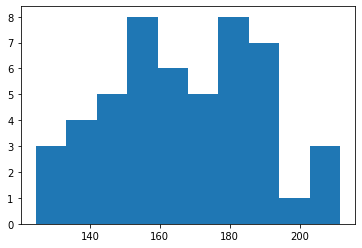

In [19]:
plt.hist(values)

In [16]:
# zmiana parametrów model.changeAssetParameter("wig20", alpha = 0.01)
# # zmiana parametrów model.changeAssetParameter("wig20", alpha = 0.01, beta = 0.0000005)
# pricing.getAssetParameters(name = "wig20")

In [17]:
pricing.getAssetParameters()

,Name,alpha,beta
0,W20,0.009626,0.000070
1,KGH,0.019139,-0.001166
